In [1]:
import pandas as pd
import pywt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import spearmanr
import datetime, pyeto
from pyeto import fao

In [2]:
fengqiao = pd.read_csv('../data/intermediate/fengqiao_interpolated.csv', index_col=0, parse_dates=True)
suzhou = pd.read_csv('../data/intermediate/suzhou_interpolated.csv', index_col=0, parse_dates=True)

discharge_fengqiao = pd.to_numeric(fengqiao['discharge']).to_numpy()
water_level_fengqiao = pd.to_numeric(fengqiao['water_level']).to_numpy()
precipitation_fengqiao = pd.to_numeric(fengqiao['precipitation']).to_numpy()

water_level_suzhou = pd.to_numeric(suzhou['water_level']).to_numpy()
precipitation_suzhou = pd.to_numeric(suzhou['precipitation']).to_numpy()

# 相关性检验

In [64]:
corr_matrix_fengqiao = fengqiao.corr().round(2)
corr_matrix_fengqiao

,discharge,precipitation,water_level
discharge,1.00,0.10,0.66
precipitation,0.10,1.00,0.12
water_level,0.66,0.12,1.00


In [65]:
corr_matrix_suzhou = suzhou.corr().round(2)
corr_matrix_suzhou

,precipitation,water_level
precipitation,1.00,0.11
water_level,0.11,1.00


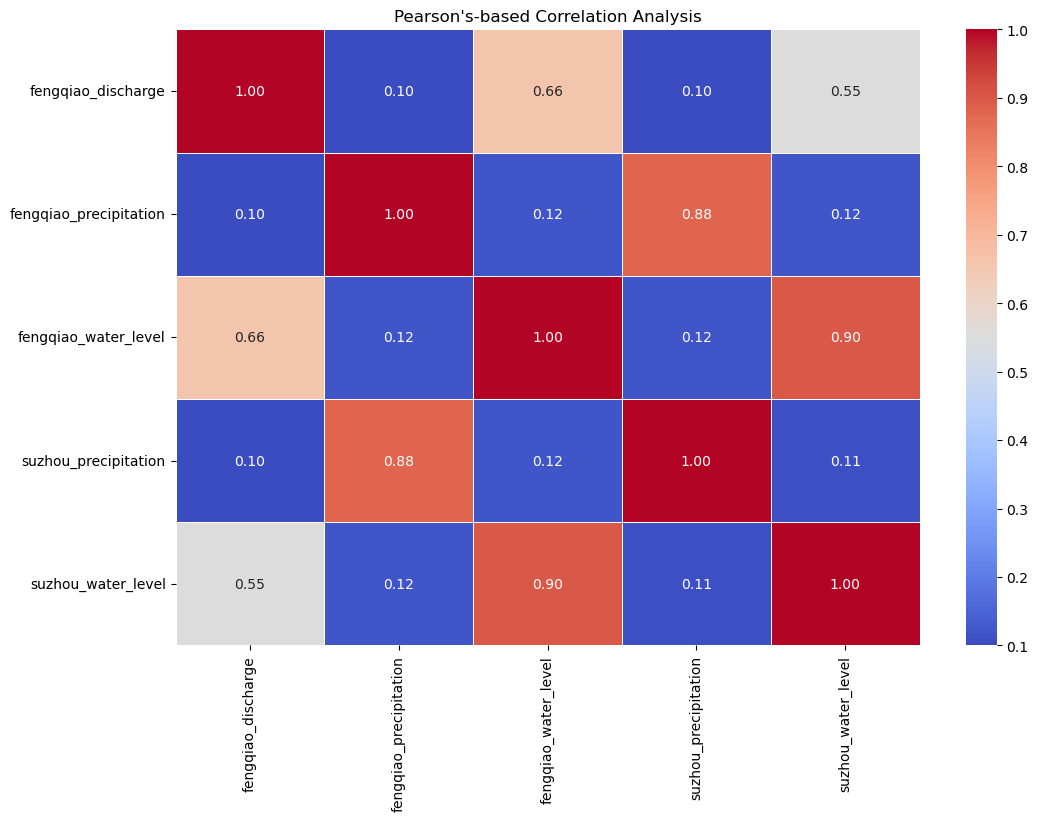

In [17]:
# 按列拼接 fengqiao 和 suzhou 数据集
combined_data = pd.concat([fengqiao.add_prefix('fengqiao_'), suzhou.add_prefix('suzhou_')], axis=1)

corr_matrix_combined = combined_data.corr().round(2)


# 绘制热力图
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix_combined, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")
plt.title("Pearson's-based Correlation Analysis")
plt.show()

通过观测相关性发现，枫桥站和苏州站在降雨和水位上的相关性较强，苏州站的部分物理规律可以使用枫桥站的；但是值得注意的是降雨和水位的相关性并不是很强，这也说明了降雨和水位之间的物理规律并不是很明显，需要借助机器学习的方法来进行建模。

In [11]:
# 对输入数据进行归一化
# 计算每个输入数据序列的 Z 分数（即，减去均值并除以标准差）
def normalize(data):
    return (data - np.mean(data)) / np.std(data)

precipitation_normalized_suzhou = normalize(precipitation_suzhou)
water_level_normalized_suzhou = normalize(water_level_suzhou)

# 计算交叉相关
cross_correlation_normalized = np.correlate(water_level_normalized_suzhou, precipitation_normalized_suzhou,'full')/len(precipitation_normalized_suzhou)

# 找到最大相关性及其滞后
max_correlation_normalized = np.max(cross_correlation_normalized)
lag_normalized = np.argmax(cross_correlation_normalized) - (len(precipitation_normalized_suzhou) - 1)

print("Cross-correlation:", cross_correlation_normalized)
print("Max correlation:", max_correlation_normalized)
print("Lag:", lag_normalized)

Cross-correlation: [ 4.76741216e-05  9.64806923e-05  1.47552161e-04 ... -1.55205176e-05
 -9.96952866e-06 -4.41853975e-06]
Max correlation: 0.22153307386225182
Lag: 3


由于数据均为日值数据，Lag 为 3 表示discharge 在 precipitation 之后有3天的时间滞后。

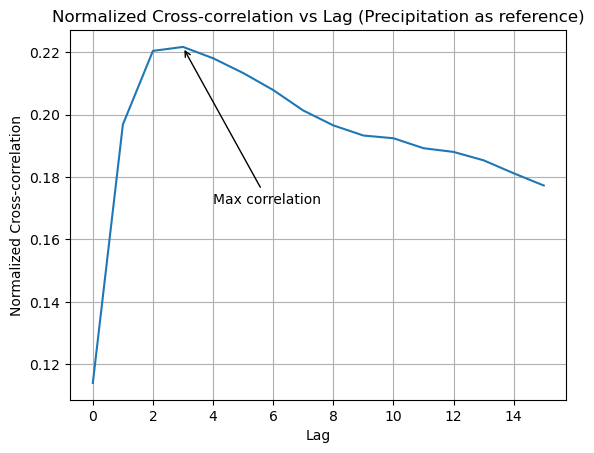

In [12]:
# 计算不同滞后值下的归一化交叉相关性
lag_range = range(0, 16)  # 从-15到15，步长为1
cross_correlation_lags_normalized = [np.correlate(precipitation_normalized_suzhou, np.roll(water_level_normalized_suzhou, -lag), 'valid')[0] / len(precipitation_normalized_suzhou) for lag in lag_range]

# 绘制归一化交叉相关性图
plt.plot(lag_range, cross_correlation_lags_normalized)
plt.xlabel('Lag')
plt.ylabel('Normalized Cross-correlation')
plt.title('Normalized Cross-correlation vs Lag (Precipitation as reference)')
plt.annotate('Max correlation', xy=(lag_normalized, max_correlation_normalized), xytext=(lag_normalized+1, max_correlation_normalized-0.05), arrowprops=dict(facecolor='black', arrowstyle='->'))
plt.grid()
plt.show()

In [16]:
corr, p_value = spearmanr(precipitation_normalized_suzhou, water_level_normalized_suzhou)
print(corr,p_value)

0.0543902630127598 1.3202185197309914e-09


Spearmanr 检验非线性相关性，结果为0.05，说明两者相关性不显著

# 季节性检验

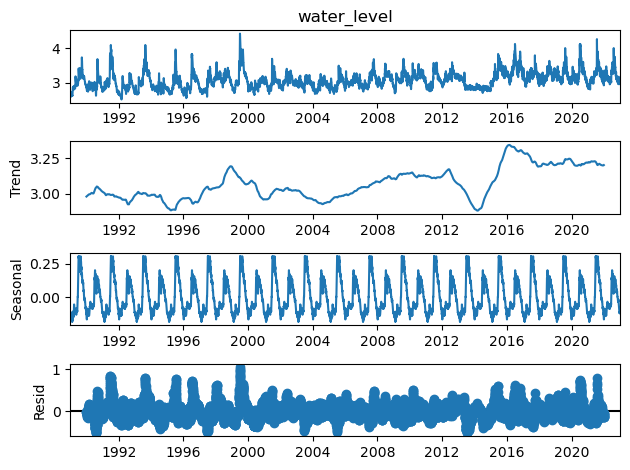

In [20]:
# decomposition
decomposition = sm.tsa.seasonal_decompose(suzhou['water_level'],period=730)
figure = decomposition.plot()
plt.show()

苏州站的水位存在着明显的季节变化，随着时间的推移，苏州站水位在不断升高，这也意味着我们有必要预测未来50年苏州站的水位变化情况。

# 自相关性检验

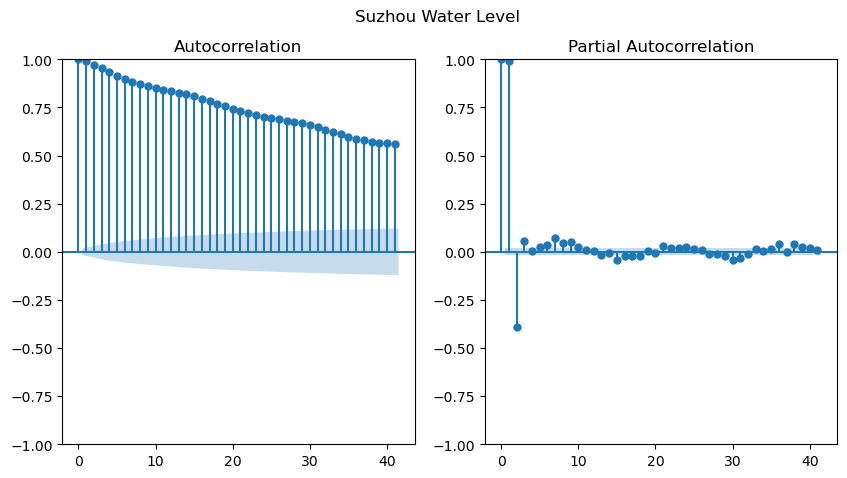

In [23]:
## 绘制自相关系数
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10, 5))
sm.graphics.tsa.plot_acf(water_level_suzhou,ax=ax[0])
sm.graphics.tsa.plot_pacf(water_level_suzhou,ax=ax[1])
plt.suptitle('Suzhou Water Level')
plt.show()

自相关系数（ACF）和偏自相关系数（PACF）是时间序列分析中常用的两个统计量，用于衡量时间序列的自相关性。

自相关系数（ACF）描述了一个时间序列与其自身在不同时间滞后的相关性。结果中，从1到40的自相关逐渐降低，这意味着时间序列的当前值与过去的值之间的相关性随着时间滞后的增加而减弱。这是时间序列中常见的现象，表明时间序列中存在某种形式的持续性或惯性。这种情况下，可以尝试对时间序列进行差分操作以消除这种自相关性。或者在使用机器学习预测时候，采用Tank模型，用水文模拟的预测值来代替真实值，满足其自相关性的特征。

偏自相关系数（PACF）测量了时间序列在给定时间滞后下的自相关性，同时排除了其他时间滞后的影响。这和滞后性检验的结果一致。

# Rating curve

找到适用于您感兴趣的河流或水库的水位-流量关系。这种关系通常可以通过实地测量或历史数据来获得。关系可以是解析函数、查找表或者拟合的曲线。rating curve又叫做stage-discharge curve，是一种经验公式，用来描述水位和流量之间的关系。

In [37]:
import numpy as np
from sklearn.metrics import mean_squared_error

def rating_curve_fengqiao(water_level, water_level_data, discharge_data):
    # 使用已知的水位和流量数据拟合一个函数（例如，多项式回归）
    coefficients = np.polyfit(water_level_data, discharge_data, deg=3)
    curve_function = np.poly1d(coefficients)

    # 根据输入的水位计算流量
    discharge = curve_function(water_level)
    return discharge, curve_function

def calculate_rmse(water_level_data, discharge_data, curve_function):
    # 计算训练数据上的预测值
    predictions = curve_function(water_level_data)

    # 计算RMSE
    mse = mean_squared_error(discharge_data, predictions)
    rmse = np.sqrt(mse)
    return rmse


# 计算流量和拟合的多项式函数
discharge_fengqiao_rating_curve, fitted_function = rating_curve_fengqiao(water_level_fengqiao, water_level_fengqiao, discharge_fengqiao)

# 计算RMSE
rmse = calculate_rmse(water_level_fengqiao, discharge_fengqiao, fitted_function)
print("RMSE:", rmse)

RMSE: 16.775860622658108


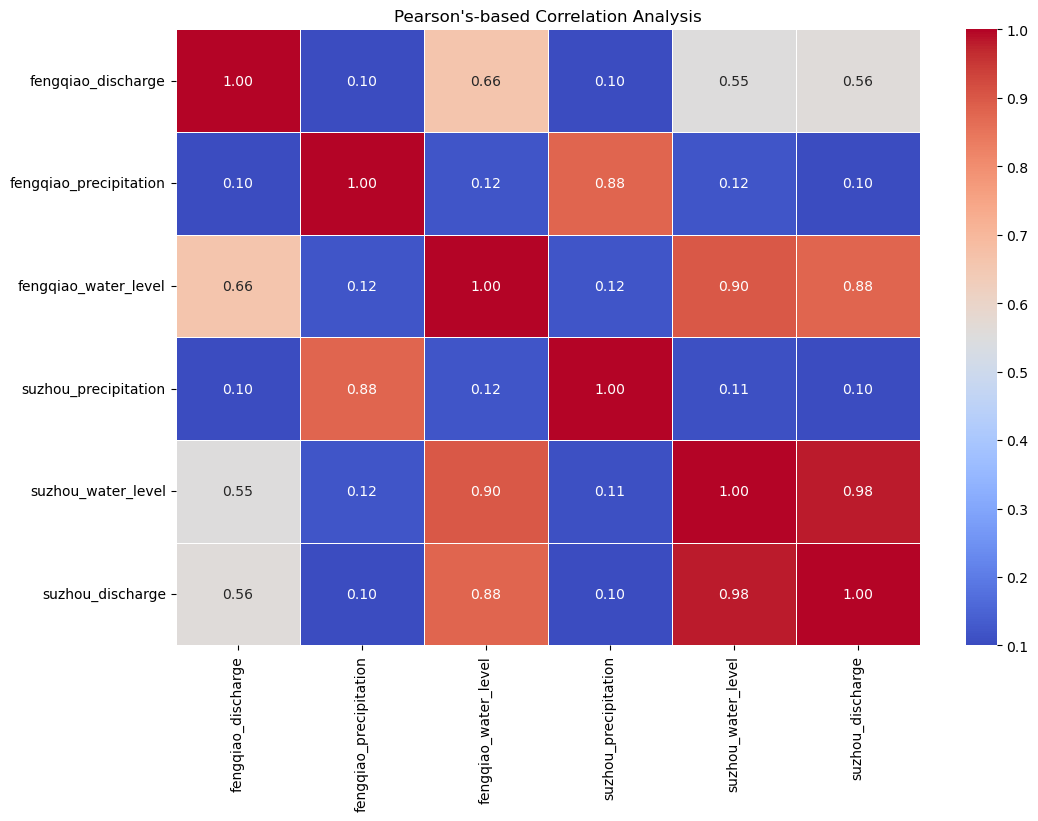

In [30]:
# 将discharge_suzhou添加到combined_data中
combined_data['suzhou_discharge'] = discharge_suzhou

corr_matrix_combined = combined_data.corr().round(2)


# 绘制热力图
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix_combined, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")
plt.title("Pearson's-based Correlation Analysis")
plt.show()

如果简单的采用rating curve去预估suzhou_discharge 会造成很大的误差，因为rating curve是基于历史数据得到的，而且rating curve是基于苏州站的数据得到的，而我们的目标是预测枫桥站的流量，所以rating curve并不适用于我们的预测。
这里我们可以考虑建立个简单的Tank模型，将标定好的Tank模型应用于训练数据集，生成模型的输出（例如，径流过程），并将这些输出作为机器学习模型的特征。

总的设计思路如下：
* 数据收集：收集降雨、蒸发、流量和水位数据。确保数据的时间范围和精度一致。

* 数据预处理：将数据划分为训练集和测试集。对数据进行归一化或标准化处理以提高模型性能。

* Tank模型参数标定：使用训练数据集对Tank模型参数进行标定。你可以使用现有的算法（例如，遗传算法、粒子群优化算法）或自己编写代码来求解最优参数。

* 利用Tank模型生成特征：将标定好的Tank模型应用于训练数据集，生成模型的输出（例如，径流过程），并将这些输出作为机器学习模型的特征。

* 选择并训练机器学习模型：选择适当的机器学习模型（例如，线性回归、支持向量机、随机森林、神经网络等），并使用训练数据集的特征和标签（水位）训练模型。

* 模型评估：使用测试数据集评估模型性能。计算评估指标（如MSE、RMSE、MAE、R-squared等），并分析模型的预测能力。

* 预测水位：应用训练好的机器学习模型，利用输入的降雨、蒸发和流量数据预测水位情况。

这是因为我们可以借助枫桥站建立一个Tank模型，根据其地形上的近似位置以及变量之间的强相关性，可以近似假设苏州站可以使用这个水文模型来进行预测。

# 气象数据

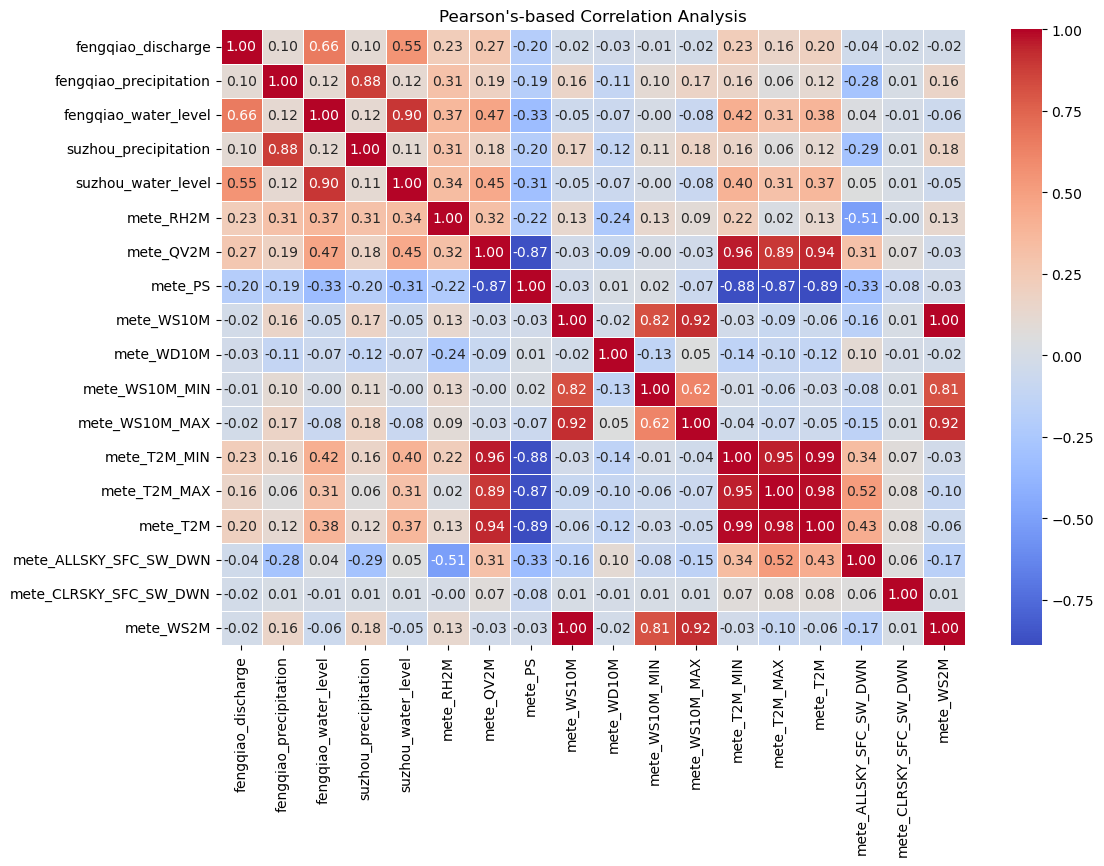

In [8]:
mete = pd.read_csv('../data/intermediate/mete.csv', index_col=0, parse_dates=True)

# 按列拼接 fengqiao 和 suzhou 数据集
combined_data = pd.concat([combined_data, mete.add_prefix('mete_')], axis=1)

corr_matrix_combined = combined_data.corr().round(2)


# 绘制热力图
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix_combined, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")
plt.title("Pearson's-based Correlation Analysis")
plt.show()

观察变量对suzhou_water_level的影响，选择2H2M,QV2M,PS,T2M作为额外变量输入到机器学习模型中。

# 蒸散发的计算

在没有蒸发测量数据的情况下，可以使用一些方法来估算蒸发。其中一种常用的方法是使用潜在蒸散发（Potential Evapotranspiration，PET）模型。潜在蒸散发是在给定气候条件下，植被完全覆盖地表且水分充足的情况下，单位时间内单位面积的最大蒸散发量。以下是一些常用的潜在蒸散发模型：

Thornthwaite模型：这是一个基于温度的模型，需要月平均气温数据。Thornthwaite模型适用于缺乏详细气象数据的情况，但在温度与蒸发之间存在非线性关系的地区可能不太准确。

Hargreaves-Samani模型：这是一个基于温度和辐射的模型，需要日最高气温和日最低气温数据。Hargreaves-Samani模型适用于只有温度数据的情况，其精度通常优于Thornthwaite模型。

Penman-Monteith模型：这是一个基于能量平衡和空气湿度平衡的综合模型，需要气温、相对湿度、风速和日照时数等气象数据。Penman-Monteith模型在各种气候条件下具有较高的精度，但需要较多的输入数据。

在使用上述模型估算潜在蒸散发后，可以将得到的值作为蒸发输入传递给Tank模型。需要注意的是，这些模型计算的是潜在蒸散发，实际蒸发可能受土壤水分状况等因素影响，因此可以考虑引入一个调整系数，以更准确地表示实际蒸发。例如，在Tank模型中，可以使用土壤湿度与田间持水量的比值作为调整系数，以调整蒸发输入。

这里我们采用Hargreaves-Samani模型来计算蒸发，因为我们只有温度数据，而且Hargreaves-Samani模型的精度优于Thornthwaite模型。

## Hargreaves-Samani

In [8]:
lat = pyeto.deg2rad(31.3)
time_index = fengqiao.index

# 计算太阳赤纬、日落时角和地球相对距离的倒数
sol_dec = np.array([pyeto.sol_dec(day) for day in time_index.dayofyear])
sha = np.array([pyeto.sunset_hour_angle(lat, sd) for sd in sol_dec])
ird = np.array([pyeto.inv_rel_dist_earth_sun(day) for day in time_index.dayofyear])

# 计算地表辐射
et_rad = np.array([pyeto.et_rad(lat, sd, sh, ir) for sd, sh, ir in zip(sol_dec, sha, ird)])

# 计算Hargreaves参考作物蒸散发
et_hargreaves = pyeto.hargreaves(mete.T2M_MIN, mete.T2M_MAX, mete.T2M, et_rad)

# 将结果存储在Pandas DataFrame中
results = pd.DataFrame({'Date': time_index, 'Hargreaves_ET': et_hargreaves})
results.set_index('Date', inplace=True)

mete['ETo'] = results['Hargreaves_ET']

In [19]:
# 提取有效变量保存起来,RH2M,QV2M,PS,T2M,ETo
mete_processed = mete[['RH2M','QV2M','PS','T2M','ETo']]
mete_processed.to_csv('../data/intermediate/mete_processed.csv')

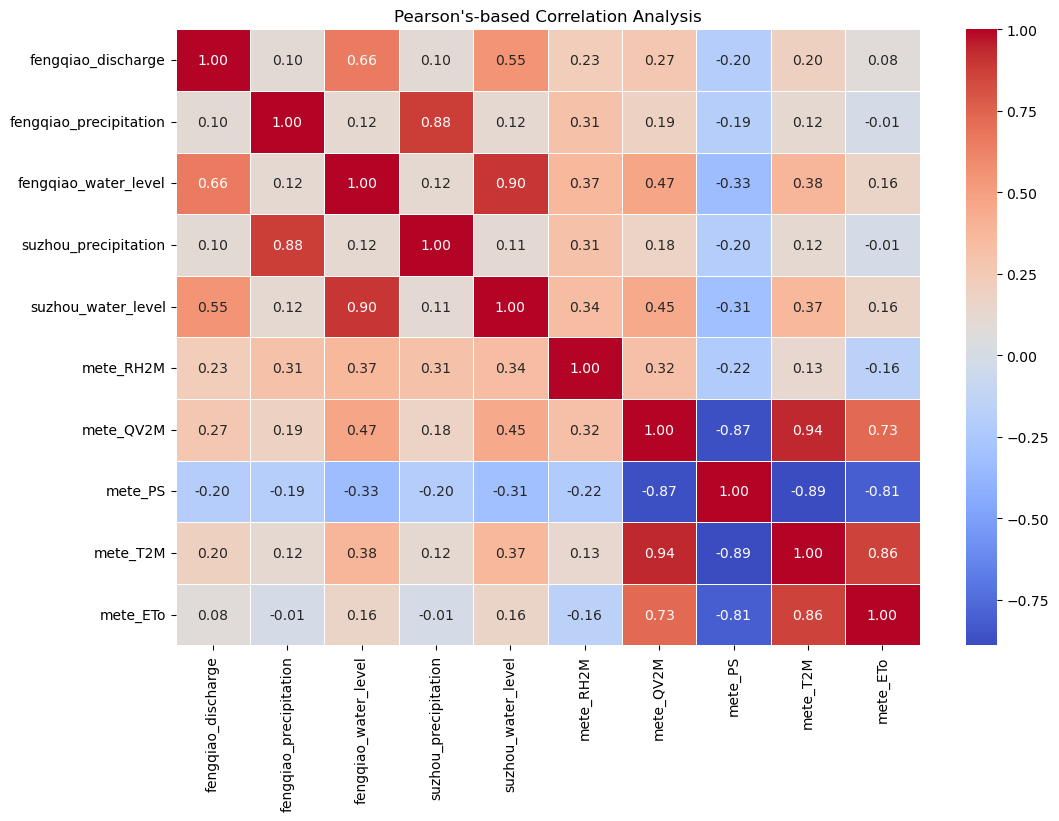

In [7]:
mete_processed = pd.read_csv('../data/intermediate/mete_processed.csv', index_col=0, parse_dates=True)


# 按列拼接 fengqiao 和 suzhou 数据集
combined_data = pd.concat([combined_data, mete_processed.add_prefix('mete_')], axis=1)

corr_matrix_combined = combined_data.corr().round(2)


# 绘制热力图
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix_combined, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")
plt.title("Pearson's-based Correlation Analysis")
plt.show()

## Penman-Monteith 

# 修改后的气象数据

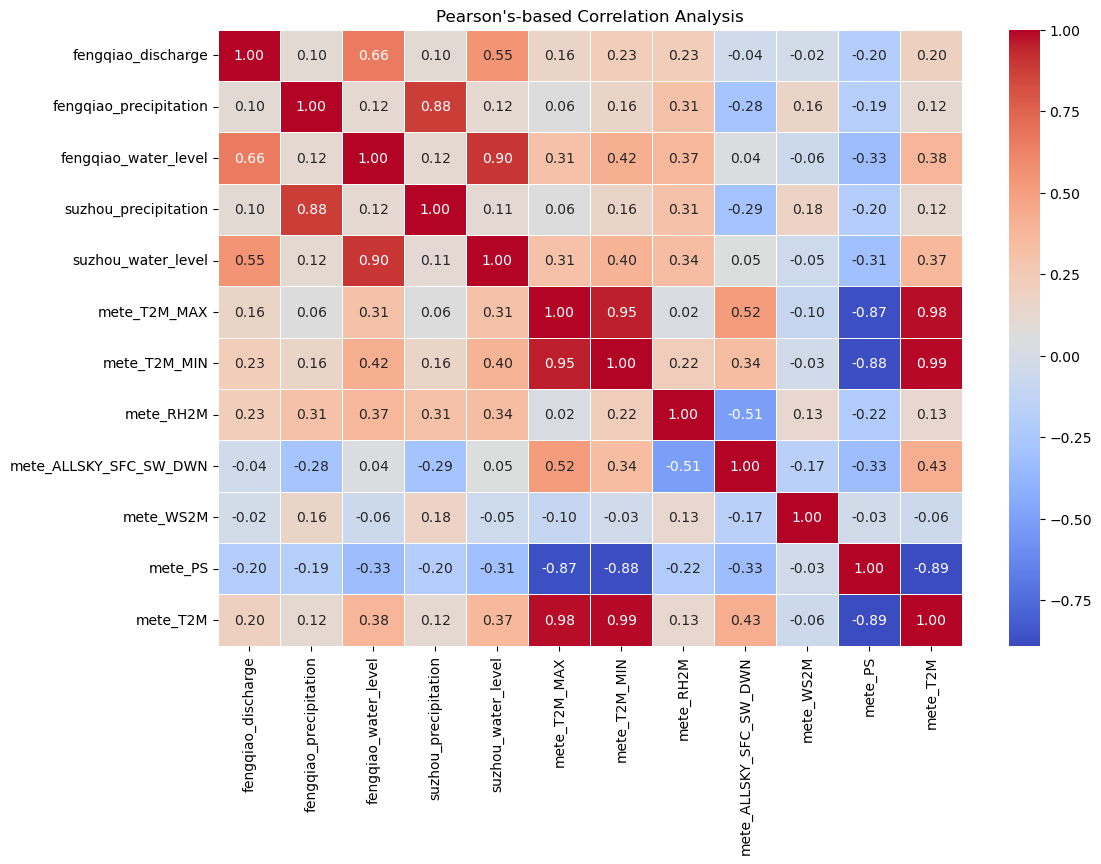

In [5]:
mete = pd.read_csv('../data/intermediate/mete.csv', index_col=0, parse_dates=True)

# 按列拼接 fengqiao 和 suzhou 数据集
combined_data = pd.concat([combined_data, mete.add_prefix('mete_')], axis=1)

corr_matrix_combined = combined_data.corr().round(2)


# 绘制热力图
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix_combined, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")
plt.title("Pearson's-based Correlation Analysis")
plt.show()

In [6]:
mete = pd.read_csv('../data/intermediate/mete.csv', index_col=0, parse_dates=True)
# 将kW-hr/m^2/day转换为MJ/m^2/day
mete['ALLSKY_SFC_SW_DWN_MJ'] = round(mete['ALLSKY_SFC_SW_DWN'] * 3.6, 2)


# 计算纬度（弧度）
latitude_rad = round(pyeto.deg2rad(31.33), 2)

# 计算FAO-56 Penman-Monteith ETo
mete['ETo_PM'] = round(mete.apply(
    lambda row: pyeto.fao56_penman_monteith(
        net_rad=row['ALLSKY_SFC_SW_DWN_MJ'],
        # t 需要进行单位转换，从摄氏度转换为开尔文
        t=row['T2M']+273.15,
        ws=row['WS2M'],
        svp=pyeto.svp_from_t(row['T2M']),
        avp=pyeto.avp_from_tmin(row['T2M_MIN']),
        delta_svp=pyeto.delta_svp(row['T2M']),
        psy=pyeto.psy_const(row['PS']),
        shf=0.0,
    ),
    axis=1,
), 2)


In [7]:
mete

,T2M_MAX,T2M_MIN,RH2M,ALLSKY_SFC_SW_DWN,WS2M,PS,T2M,ALLSKY_SFC_SW_DWN_MJ,ETo_PM
time,,,,,,,,,
1989-01-01,10.07,1.12,73.00,2.61,2.04,103.13,4.81,9.40,1.82
1989-01-02,12.39,0.13,76.44,2.13,1.65,102.68,5.83,7.67,1.83
1989-01-03,12.26,3.40,80.62,2.02,2.39,102.96,6.70,7.27,1.60
1989-01-04,12.15,4.04,69.94,1.22,3.62,103.20,7.05,4.39,1.24
1989-01-05,12.61,3.19,76.69,2.28,3.02,102.77,7.32,8.21,1.94
...,...,...,...,...,...,...,...,...,...
2022-12-27,8.31,-2.52,78.69,2.75,1.41,103.03,2.28,9.90,1.80
2022-12-28,7.74,0.19,82.88,1.67,2.12,103.19,3.28,6.01,1.20
2022-12-29,6.32,0.17,77.00,1.28,1.89,103.37,2.78,4.61,0.93


In [12]:
lat = pyeto.deg2rad(31.3)
time_index = fengqiao.index

# 计算太阳赤纬、日落时角和地球相对距离的倒数
sol_dec = np.array([pyeto.sol_dec(day) for day in time_index.dayofyear])
sha = np.array([pyeto.sunset_hour_angle(lat, sd) for sd in sol_dec])
ird = np.array([pyeto.inv_rel_dist_earth_sun(day) for day in time_index.dayofyear])

# 计算地表辐射
et_rad = np.array([pyeto.et_rad(lat, sd, sh, ir) for sd, sh, ir in zip(sol_dec, sha, ird)])

# 计算Hargreaves参考作物蒸散发
mete['ETo_HS'] = round(pyeto.hargreaves(mete.T2M_MIN, mete.T2M_MAX, mete.T2M, et_rad),2)

In [13]:
mete

,T2M_MAX,T2M_MIN,RH2M,ALLSKY_SFC_SW_DWN,WS2M,PS,T2M,ALLSKY_SFC_SW_DWN_MJ,ETo_PM,ETo_HS
time,,,,,,,,,,
1989-01-01,10.07,1.12,73.00,2.61,2.04,103.13,4.81,9.40,1.82,1.22
1989-01-02,12.39,0.13,76.44,2.13,1.65,102.68,5.83,7.67,1.83,1.49
1989-01-03,12.26,3.40,80.62,2.02,2.39,102.96,6.70,7.27,1.60,1.32
1989-01-04,12.15,4.04,69.94,1.22,3.62,103.20,7.05,4.39,1.24,1.29
1989-01-05,12.61,3.19,76.69,2.28,3.02,102.77,7.32,8.21,1.94,1.41
...,...,...,...,...,...,...,...,...,...,...
2022-12-27,8.31,-2.52,78.69,2.75,1.41,103.03,2.28,9.90,1.80,1.18
2022-12-28,7.74,0.19,82.88,1.67,2.12,103.19,3.28,6.01,1.20,1.03
2022-12-29,6.32,0.17,77.00,1.28,1.89,103.37,2.78,4.61,0.93,0.91


In [14]:
mete.to_csv('../data/intermediate/mete_processed.csv')

要计算实际蒸散发，您需要首先计算参考作物蒸散发（ETo），然后乘以作物系数（Kc）

苏州工业园区位于江苏省苏州市，该地区的主要作物包括水稻、小麦、油菜等。作物系数（Kc）值取决于作物类型和生长阶段，因此首先需要确定研究区域的主要作物类型。

在此示例中，我们提供水稻的Kc值作为参考。对于水稻，Kc值通常分为三个生长阶段：

1. 初始阶段（Kc_ini）：发芽到生长初期，Kc值约为0.4-0.5。
2. 中间阶段（Kc_mid）：植株快速生长期，Kc值约为1.0-1.2。
3. 末期阶段（Kc_end）：成熟和收割阶段，Kc值约为0.6-0.7。

需要注意的是，Kc值因作物类型、品种、种植条件以及气候条件而异。在实际应用中，建议查阅本地气象部门、农业部门或研究机构提供的相关资料以获取更精确的Kc值。另外，也可以根据实际蒸散发观测数据进行Kc值的校正。

这里为了计算方便我们将会使用统一的Kc作物系数，反应当地植被情况，使用统一的植被系数可以简化计算，但是会引入一定的误差。
考虑长时间序列，这也为规划中的农业生产提供了参考。

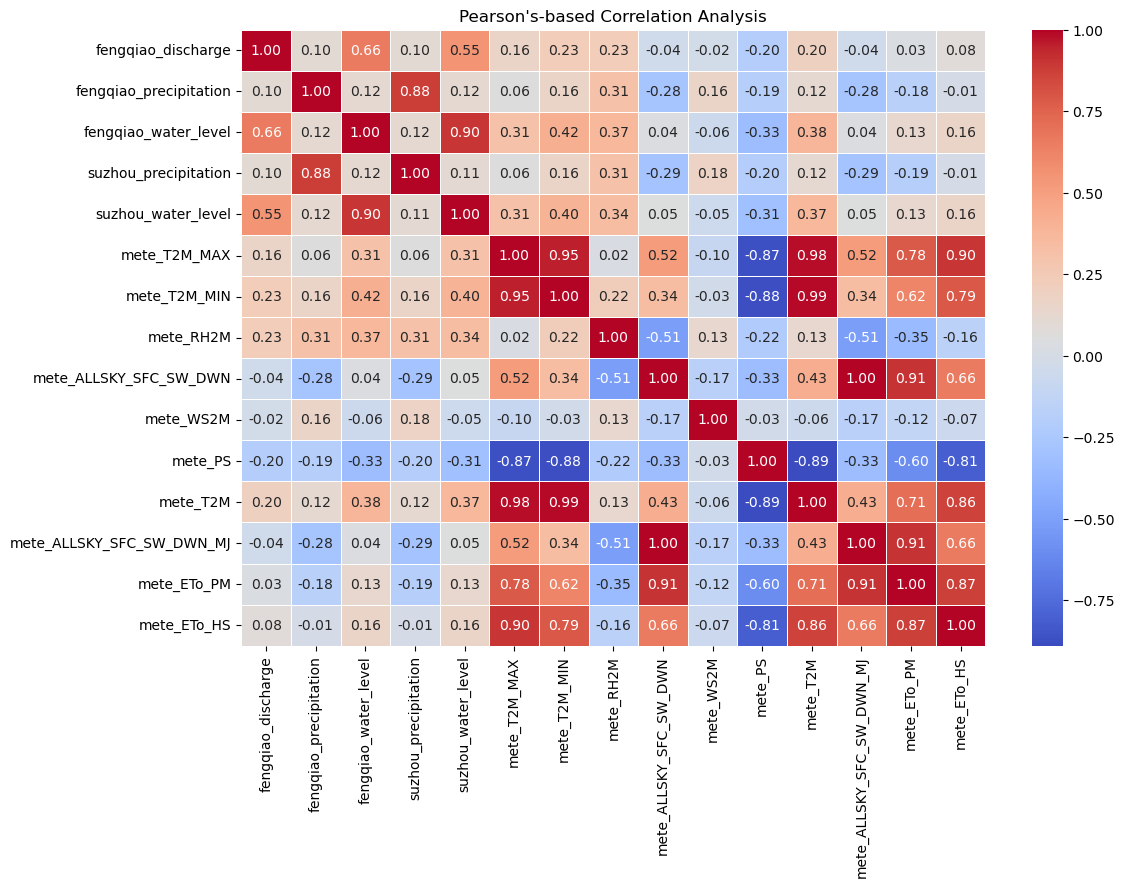

In [18]:
mete_processed = pd.read_csv('../data/intermediate/mete_processed.csv', index_col=0, parse_dates=True)

# 按列拼接 fengqiao 和 suzhou 数据集
combined_data = pd.concat([combined_data, mete_processed.add_prefix('mete_')], axis=1)

corr_matrix_combined = combined_data.corr().round(2)


# 绘制热力图
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix_combined, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")
plt.title("Pearson's-based Correlation Analysis")
plt.show()

相关性分析下来ETo_PM方法和precipitation的相关性更强，但是和discharge还有water_level的相关性很差；后续需要模型验证才知道哪种方法更好。